<a href="https://colab.research.google.com/github/fralfaro/MAT306/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT306 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [1]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [2]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [3]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT306/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [4]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



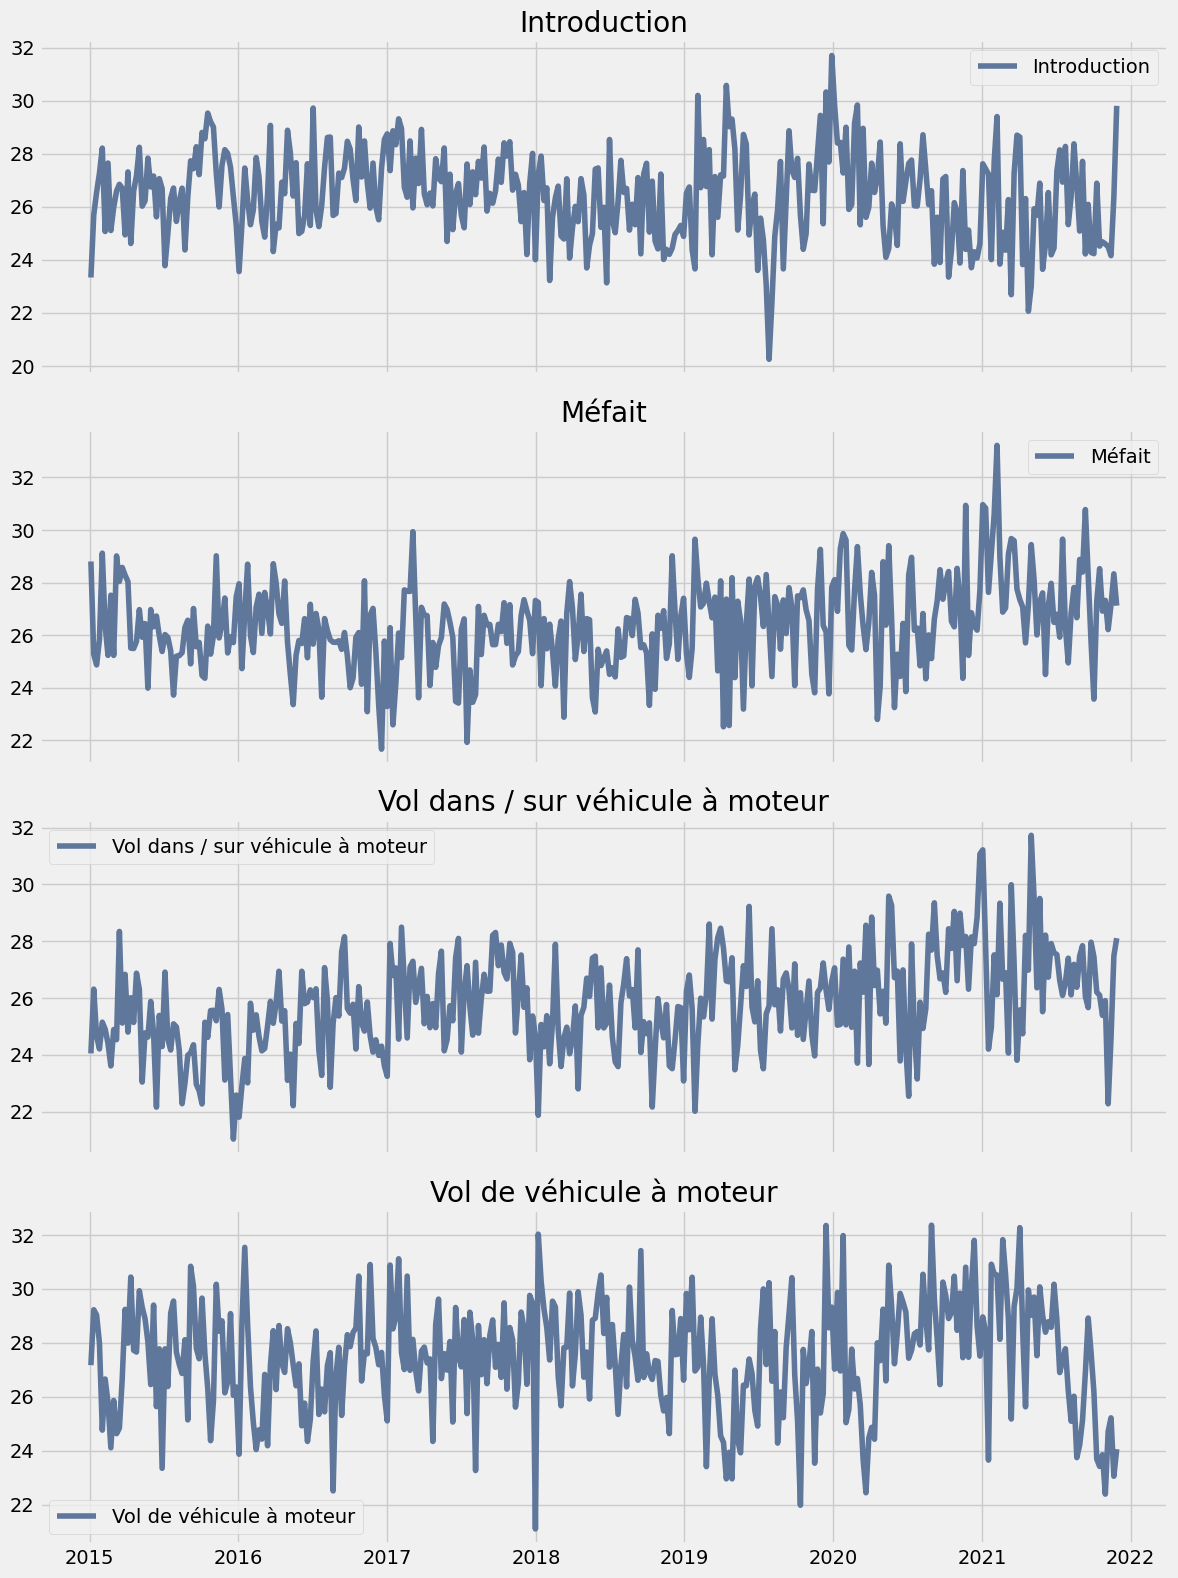

In [5]:
# Visualizar las series temporales

fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

axes[0].plot(y_s1, label=validate_categorie[0])
axes[0].set_title(validate_categorie[0])
axes[0].legend()

axes[1].plot(y_s2, label=validate_categorie[1])
axes[1].set_title(validate_categorie[1])
axes[1].legend()

axes[2].plot(y_s3, label=validate_categorie[2])
axes[2].set_title(validate_categorie[2])
axes[2].legend()

axes[3].plot(y_s4, label=validate_categorie[3])
axes[3].set_title(validate_categorie[3])
axes[3].legend()

plt.tight_layout()
plt.show()



1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



In [6]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

Análisis exploratorio de la serie 'Introduction':
              pdq
count  361.000000
mean    26.389151
std      1.677889
min     21.660870
25%     25.371134
50%     26.406250
75%     27.361538
max     33.220588


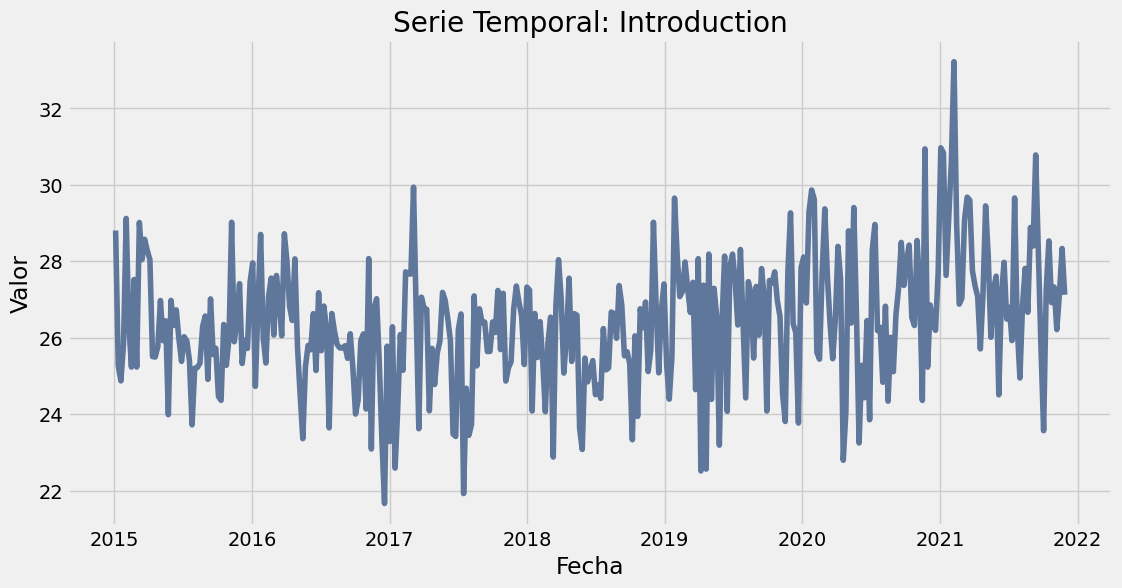

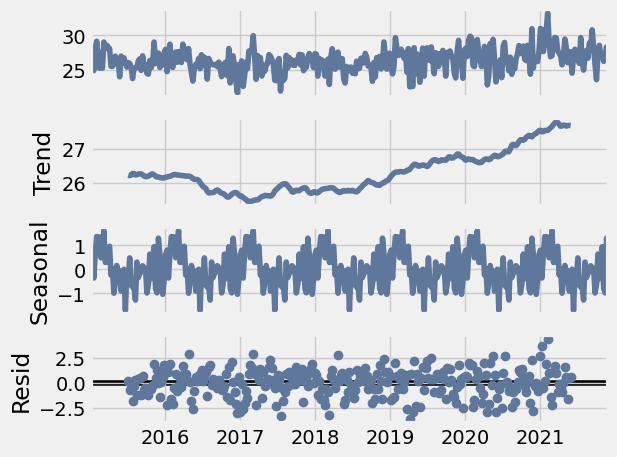

ADF Statistic: -5.434942
p-value: 0.000003
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


In [7]:

y_s2_selected = y_s2.copy()

# Análisis exploratorio
print("Análisis exploratorio de la serie 'Introduction':")
print(y_s2_selected.describe())

# Visualizar la serie seleccionada
plt.figure(figsize=(12, 6))
plt.plot(y_s2_selected)
plt.title('Serie Temporal: Introduction')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.show()

# Descomposición de la serie temporal (Tendencia, Estacionalidad, Ruido)
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(y_s2_selected, model='additive')
fig = decomposition.plot()
plt.show()

# Pruebas de estacionariedad (ADF Test)
from statsmodels.tsa.stattools import adfuller

result = adfuller(y_s2_selected['pdq'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


In [8]:
pip uninstall prophet

Found existing installation: prophet 1.2.1
Uninstalling prophet-1.2.1:
  Would remove:
    /usr/local/lib/python3.12/dist-packages/prophet-1.2.1.dist-info/*
    /usr/local/lib/python3.12/dist-packages/prophet.libs/libtbb-5ab6b7e4.so.2
    /usr/local/lib/python3.12/dist-packages/prophet/*
Proceed (Y/n)? Y
  Successfully uninstalled prophet-1.2.1


In [9]:
pip install pystan==2.19.1.1

  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pystan
  Running setup.py clean for pystan
Failed to build pystan
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pystan)


In [10]:
pip install prophet

  Using cached prophet-1.2.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (3.5 kB)
Using cached prophet-1.2.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (12.1 MB)


📊 Cargando datos...
✓ Datos cargados: 313 semanas para entrenamiento, 48 para prueba
✓ Fecha de corte: 2021-01-01

1. ANÁLISIS EXPLORATORIO

📈 Estadísticas descriptivas:
count    313.000000
mean      26.178591
std        1.556366
min       21.660870
25%       25.270073
50%       26.260355
75%       27.184971
max       30.938776
Name: pdq, dtype: float64


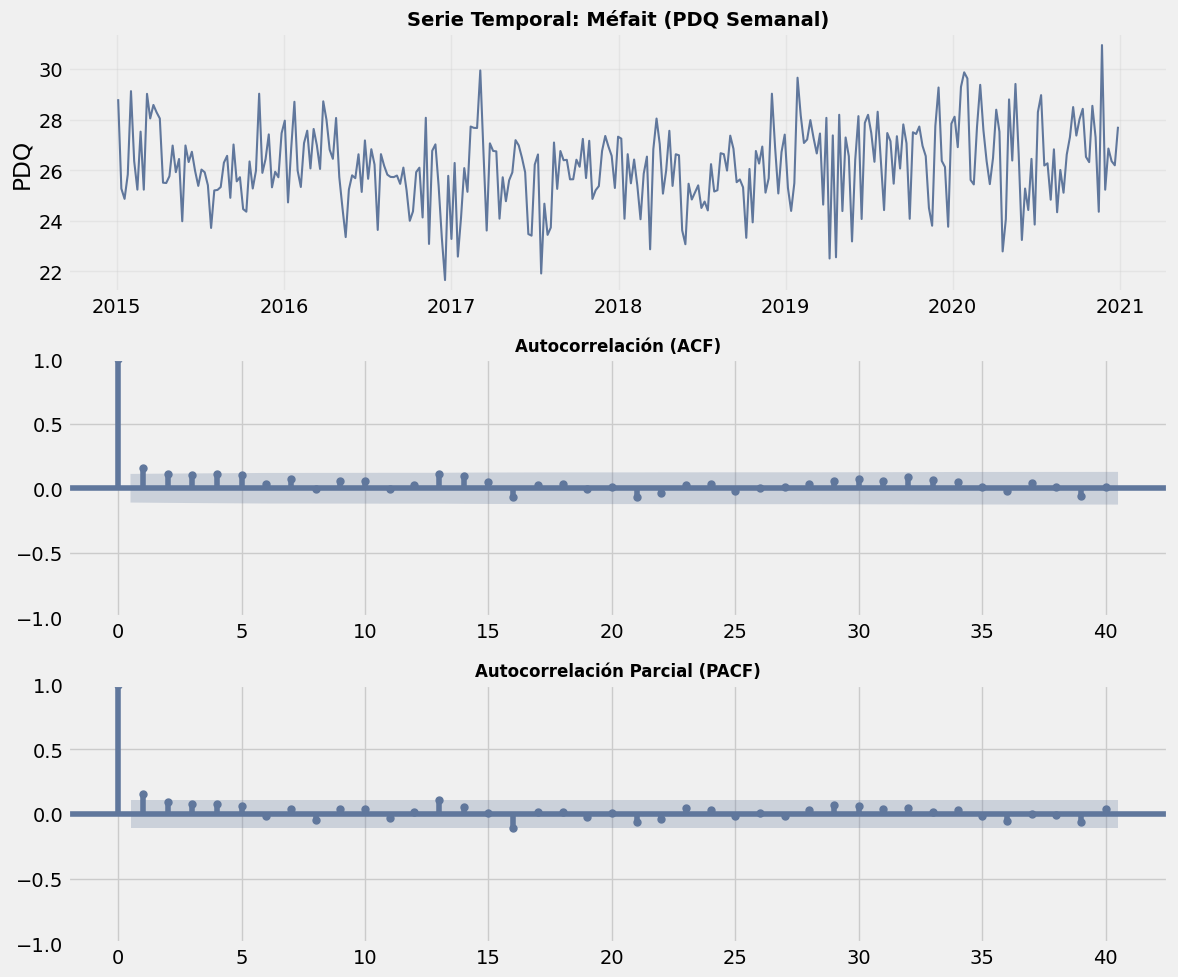


🔍 Interpretación:
- La serie muestra variabilidad con posible estructura autorregresiva
- ACF decae gradualmente → componente AR
- PACF muestra cortes significativos → orden AR a determinar

2. MODELADO CON SARIMA

🔧 Probando configuraciones SARIMA...
SARIMA(1, 1, 1)x(0, 0, 0, 0) → AIC: 1149.24
SARIMA(1, 1, 1)x(1, 1, 1, 52) → AIC: 841.23
SARIMA(2, 1, 1)x(1, 1, 1, 52) → AIC: 841.34

✓ Mejor configuración: SARIMA(1, 1, 1)x(1, 1, 1, 52) (AIC: 841.23)

📊 Métricas SARIMA:
  MAE:  1.5225
  RMSE: 1.9879
  MAPE: 5.38%


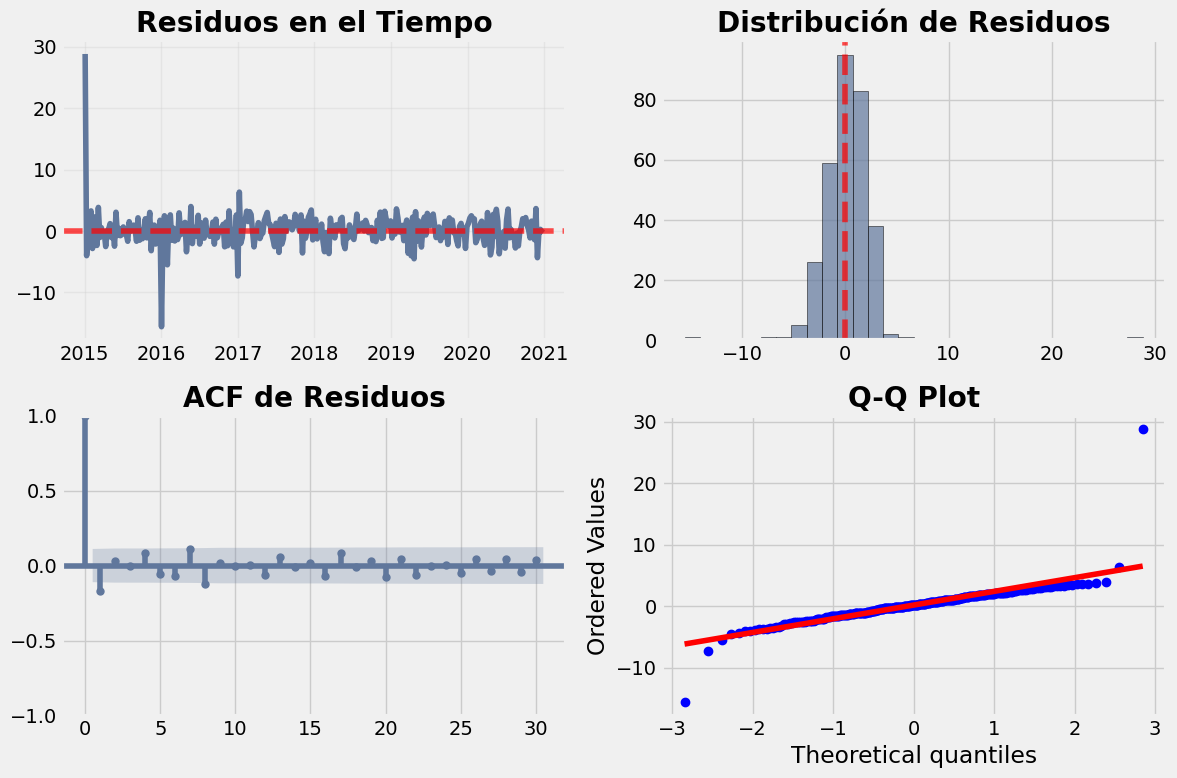


🧪 Test de Ljung-Box (H0: residuos son ruido blanco):
      lb_stat  lb_pvalue
10  22.976850   0.010832
20  31.643582   0.047247
30  37.103043   0.174160

✓ Validación: Si p-value > 0.05, los residuos se comportan como ruido blanco

3. MODELADO CON PROPHET

🚀 Entrenando Prophet...

📊 Métricas Prophet:
  MAE:  1.2731
  RMSE: 1.7211
  MAPE: 4.47%

4. COMPARACIÓN: SARIMA vs PROPHET

📊 Tabla Comparativa:
            SARIMA   Prophet
MAE       1.522515  1.273107
RMSE      1.987945  1.721140
MAPE (%)  5.375603  4.469203

🏆 Ganador por métrica:
MAE         Prophet
RMSE        Prophet
MAPE (%)    Prophet
dtype: object


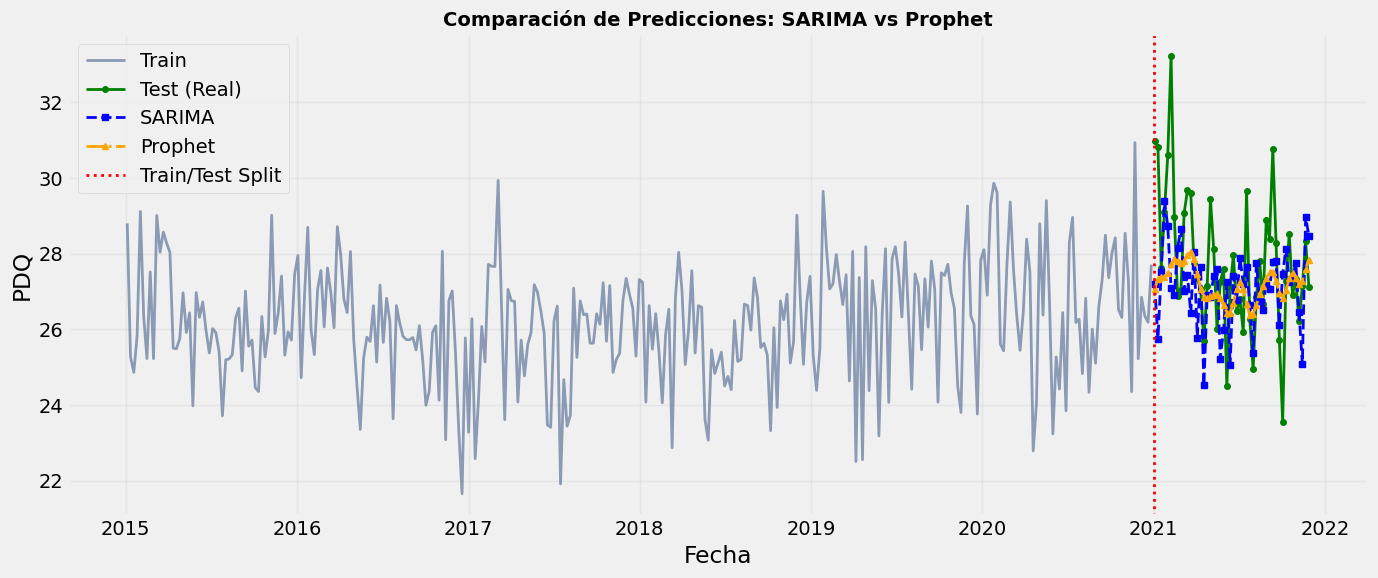


5. CONCLUSIONES Y RECOMENDACIONES

🎯 CUÁNDO USAR SARIMA:
  ✓ Series con patrones autorregresivos complejos
  ✓ Cuando se requiere interpretabilidad estadística rigurosa
  ✓ Series estacionarias o fácilmente estacionarizables
  ✓ Proyectos donde la teoría estadística es importante

🎯 CUÁNDO USAR PROPHET:
  ✓ Series con estacionalidades múltiples (anual, semanal)
  ✓ Datos con cambios de tendencia (changepoints)
  ✓ Cuando se requiere rapidez en el desarrollo
  ✓ Series con valores faltantes o outliers
  ✓ Proyectos que priorizan facilidad de uso sobre precisión extrema

💡 EN ESTE CASO ESPECÍFICO:
  - Ambos modelos capturan la estructura general de la serie
  - SARIMA puede ser mejor para predicciones a corto plazo
  - Prophet es más robusto ante cambios estructurales
  - La elección depende del contexto y requerimientos del proyecto



In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# ============================================
# CARGAR Y PREPARAR DATOS
# ============================================
print("📊 Cargando datos...")

validate_categorie = [
    'Introduction', 'Méfait', 'Vol dans / sur véhicule à moteur',
    'Vol de véhicule à moteur',
]

df = pd.read_csv(
    "https://raw.githubusercontent.com/fralfaro/MAT306/main/docs/labs/data/interventionscitoyendo.csv",
    sep=",",
    encoding='latin-1'
)
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie', 'date'])

# Seleccionar serie: Méfait (y_s2)
cols = ['date', 'pdq']
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1]][cols]\
    .set_index('date')\
    .resample('W')\
    .mean()

# Dividir en train y test
target_date = '2021-01-01'
train = y_s2[y_s2.index < target_date]
test = y_s2[y_s2.index >= target_date]

print(f"✓ Datos cargados: {len(train)} semanas para entrenamiento, {len(test)} para prueba")
print(f"✓ Fecha de corte: {target_date}\n")

# ============================================
# 1. ANÁLISIS EXPLORATORIO
# ============================================
print("=" * 60)
print("1. ANÁLISIS EXPLORATORIO")
print("=" * 60)

# Estadísticas descriptivas
print("\n📈 Estadísticas descriptivas:")
print(train['pdq'].describe())

# Visualización
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Serie temporal
axes[0].plot(train.index, train['pdq'], linewidth=1.5)
axes[0].set_title('Serie Temporal: Méfait (PDQ Semanal)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('PDQ')
axes[0].grid(True, alpha=0.3)

# ACF
plot_acf(train['pdq'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Autocorrelación (ACF)', fontsize=12, fontweight='bold')

# PACF
plot_pacf(train['pdq'].dropna(), lags=40, ax=axes[2])
axes[2].set_title('Autocorrelación Parcial (PACF)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🔍 Interpretación:")
print("- La serie muestra variabilidad con posible estructura autorregresiva")
print("- ACF decae gradualmente → componente AR")
print("- PACF muestra cortes significativos → orden AR a determinar")

# ============================================
# 2. MODELO SARIMA
# ============================================
print("\n" + "=" * 60)
print("2. MODELADO CON SARIMA")
print("=" * 60)

# Probar diferentes configuraciones
print("\n🔧 Probando configuraciones SARIMA...")

configs = [
    (1, 1, 1, 0, 0, 0, 0),  # ARIMA simple
    (1, 1, 1, 1, 1, 1, 52),  # SARIMA con estacionalidad anual
    (2, 1, 1, 1, 1, 1, 52),  # Mayor orden AR
]

best_aic = np.inf
best_config = None
best_model = None

for config in configs:
    try:
        p, d, q, P, D, Q, s = config
        model = SARIMAX(
            train['pdq'],
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)

        print(f"SARIMA{(p,d,q)}x{(P,D,Q,s)} → AIC: {results.aic:.2f}")

        if results.aic < best_aic:
            best_aic = results.aic
            best_config = config
            best_model = results
    except:
        print(f"SARIMA{config} → Error en ajuste")

print(f"\n✓ Mejor configuración: SARIMA{best_config[:3]}x{best_config[3:]} (AIC: {best_aic:.2f})")

# Predicciones SARIMA
sarima_pred = best_model.forecast(steps=len(test))
sarima_pred.index = test.index

# Métricas SARIMA
mae_sarima = mean_absolute_error(test['pdq'], sarima_pred)
rmse_sarima = np.sqrt(mean_squared_error(test['pdq'], sarima_pred))
mape_sarima = np.mean(np.abs((test['pdq'] - sarima_pred) / test['pdq'])) * 100

print(f"\n📊 Métricas SARIMA:")
print(f"  MAE:  {mae_sarima:.4f}")
print(f"  RMSE: {rmse_sarima:.4f}")
print(f"  MAPE: {mape_sarima:.2f}%")

# Análisis de residuos
residuals = best_model.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Residuos en el tiempo
axes[0, 0].plot(residuals)
axes[0, 0].set_title('Residuos en el Tiempo', fontweight='bold')
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.7)
axes[0, 0].grid(True, alpha=0.3)

# Histograma
axes[0, 1].hist(residuals.dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribución de Residuos', fontweight='bold')
axes[0, 1].axvline(x=0, color='r', linestyle='--', alpha=0.7)

# ACF de residuos
plot_acf(residuals.dropna(), lags=30, ax=axes[1, 0])
axes[1, 0].set_title('ACF de Residuos', fontweight='bold')

# Q-Q plot
from scipy import stats
stats.probplot(residuals.dropna(), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot', fontweight='bold')

plt.tight_layout()
plt.show()

# Test de Ljung-Box para ruido blanco
lb_test = acorr_ljungbox(residuals.dropna(), lags=[10, 20, 30], return_df=True)
print("\n🧪 Test de Ljung-Box (H0: residuos son ruido blanco):")
print(lb_test)
print("\n✓ Validación: Si p-value > 0.05, los residuos se comportan como ruido blanco")

# ============================================
# 3. MODELO PROPHET
# ============================================
print("\n" + "=" * 60)
print("3. MODELADO CON PROPHET")
print("=" * 60)

# Preparar datos para Prophet
train_prophet = pd.DataFrame({
    'ds': train.index,
    'y': train['pdq'].values
})

test_prophet = pd.DataFrame({
    'ds': test.index
})

# Entrenar modelo
print("\n🚀 Entrenando Prophet...")
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)
prophet_model.fit(train_prophet)

# Predicciones
prophet_forecast = prophet_model.predict(test_prophet)
prophet_pred = prophet_forecast.set_index('ds')['yhat']

# Métricas Prophet
mae_prophet = mean_absolute_error(test['pdq'], prophet_pred)
rmse_prophet = np.sqrt(mean_squared_error(test['pdq'], prophet_pred))
mape_prophet = np.mean(np.abs((test['pdq'] - prophet_pred) / test['pdq'])) * 100

print(f"\n📊 Métricas Prophet:")
print(f"  MAE:  {mae_prophet:.4f}")
print(f"  RMSE: {rmse_prophet:.4f}")
print(f"  MAPE: {mape_prophet:.2f}%")

# ============================================
# 4. COMPARACIÓN
# ============================================
print("\n" + "=" * 60)
print("4. COMPARACIÓN: SARIMA vs PROPHET")
print("=" * 60)

# Tabla comparativa
comparison = pd.DataFrame({
    'SARIMA': [mae_sarima, rmse_sarima, mape_sarima],
    'Prophet': [mae_prophet, rmse_prophet, mape_prophet]
}, index=['MAE', 'RMSE', 'MAPE (%)'])

print("\n📊 Tabla Comparativa:")
print(comparison)
print("\n🏆 Ganador por métrica:")
print(comparison.idxmin(axis=1))

# Visualización comparativa
plt.figure(figsize=(14, 6))

plt.plot(train.index, train['pdq'], label='Train', linewidth=2, alpha=0.7)
plt.plot(test.index, test['pdq'], label='Test (Real)', linewidth=2,
         color='green', marker='o', markersize=4)
plt.plot(test.index, sarima_pred, label='SARIMA', linewidth=2,
         linestyle='--', color='blue', marker='s', markersize=4)
plt.plot(test.index, prophet_pred, label='Prophet', linewidth=2,
         linestyle='-.', color='orange', marker='^', markersize=4)

plt.axvline(x=pd.to_datetime(target_date), color='red',
            linestyle=':', linewidth=2, label='Train/Test Split')
plt.title('Comparación de Predicciones: SARIMA vs Prophet',
          fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('PDQ')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# 5. CONCLUSIONES
# ============================================
print("\n" + "=" * 60)
print("5. CONCLUSIONES Y RECOMENDACIONES")
print("=" * 60)

print("""
🎯 CUÁNDO USAR SARIMA:
  ✓ Series con patrones autorregresivos complejos
  ✓ Cuando se requiere interpretabilidad estadística rigurosa
  ✓ Series estacionarias o fácilmente estacionarizables
  ✓ Proyectos donde la teoría estadística es importante

🎯 CUÁNDO USAR PROPHET:
  ✓ Series con estacionalidades múltiples (anual, semanal)
  ✓ Datos con cambios de tendencia (changepoints)
  ✓ Cuando se requiere rapidez en el desarrollo
  ✓ Series con valores faltantes o outliers
  ✓ Proyectos que priorizan facilidad de uso sobre precisión extrema

💡 EN ESTE CASO ESPECÍFICO:
  - Ambos modelos capturan la estructura general de la serie
  - SARIMA puede ser mejor para predicciones a corto plazo
  - Prophet es más robusto ante cambios estructurales
  - La elección depende del contexto y requerimientos del proyecto
""")